In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

In [4]:
train = pd.read_csv('./train.csv')

In [5]:
test = pd.read_csv('./test.csv')

In [6]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [7]:
def Title(name):
    return name.split(',')[1].split('.')[0].strip()

In [8]:
train['Name'].apply(Title).value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
the Countess      1
Jonkheer          1
Ms                1
Sir               1
Lady              1
Don               1
Mme               1
Capt              1
Name: Name, dtype: int64

In [9]:
def CleanTitle(title):
    titles =['Mr','Miss','Mrs','Master','Dr','Rev']
    if title == 'Ms':
        return 'Miss'
    elif title not in titles:
        return 'Other'
    else:
        return title

In [10]:
train['Name'].apply(Title).apply(CleanTitle).value_counts()

Mr        517
Miss      183
Mrs       125
Master     40
Other      13
Dr          7
Rev         6
Name: Name, dtype: int64

In [11]:
train['Title'] = train['Name'].apply(Title).apply(CleanTitle)
test['Title'] = test['Name'].apply(Title).apply(CleanTitle)

In [12]:
def CabinLetter(cabin):
    try:
        return cabin[0]
    except:
        return 'Missing'

In [13]:
train['Cabin'].apply(CabinLetter).value_counts()

Missing    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Cabin, dtype: int64

In [14]:
def CleanCabinLetter(letter):
    letters = ['A','B','C','D','E','F']
    if letter in letters:
        return letter
    else:
        return 'Missing'

In [15]:
train['Cabin'].apply(CabinLetter).apply(CleanCabinLetter).value_counts()

Missing    692
C           59
B           47
D           33
E           32
A           15
F           13
Name: Cabin, dtype: int64

In [16]:
train['CabinLetter'] = train['Cabin'].apply(CabinLetter).apply(CleanCabinLetter)
test['CabinLetter'] = test['Cabin'].apply(CabinLetter).apply(CleanCabinLetter)

In [17]:
ds_tickets = train['Ticket'].value_counts().reset_index().rename(columns={'Ticket': 'TicketCount'})
train = train.merge(ds_tickets, how='left', left_on='Ticket', right_on='index').drop('index',axis=1)

In [18]:
ds_tickets = test['Ticket'].value_counts().reset_index().rename(columns={'Ticket': 'TicketCount'})
test = test.merge(ds_tickets, how='left', left_on='Ticket', right_on='index').drop('index',axis=1) 

In [19]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,CabinLetter,TicketCount
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Mr,Missing,1


In [20]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
CabinLetter      0
TicketCount      0
dtype: int64

In [21]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Title            0
CabinLetter      0
TicketCount      0
dtype: int64

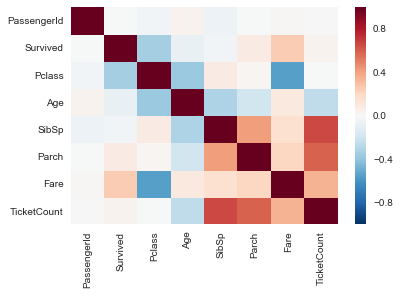

In [22]:
sns.heatmap(train.corr())

In [23]:
ds_age = pd.concat([train[['Age','Pclass']],test[['Age','Pclass']]])
ds_age.groupby('Pclass').agg({'Age':np.median})

,Age
Pclass,
1,39.0
2,29.0
3,24.0


In [24]:
def ImputeAge(cols):
    age = cols[0]
    pclass = cols[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return 39
        elif pclass == 2:
            return 29
        else:
            return 24
    else:
        return age

In [25]:
train['Age'] = train[['Age','Pclass']].apply(ImputeAge, axis=1)
test['Age'] = test[['Age','Pclass']].apply(ImputeAge, axis=1)

In [26]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
CabinLetter      0
TicketCount      0
dtype: int64

In [27]:
train.drop(['Name','Ticket','Cabin'], axis=1, inplace = True)
test.drop(['Name','Ticket','Cabin'], axis=1, inplace = True)

In [28]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
Title          0
CabinLetter    0
TicketCount    0
dtype: int64

In [29]:
test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Embarked       0
Title          0
CabinLetter    0
TicketCount    0
dtype: int64

In [30]:
train.dropna(inplace=True)

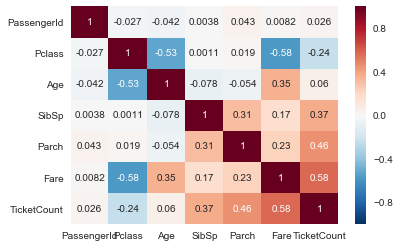

In [31]:
sns.heatmap(test.corr(), annot=True)

In [32]:
test.groupby(['Pclass','TicketCount']).agg({'Fare': [np.mean,np.median]})

Fare           
                          mean     median
Pclass TicketCount                       
1      1             62.600818   42.45000
       2            104.985585   82.26670
       3            178.139600  178.13960
       4            211.500000  211.50000
       5            262.375000  262.37500
2      1             17.214430   13.00000
       2             32.638889   26.00000
       3             48.250000   48.25000
3      1              9.919933    7.85420
       2             20.676136   20.57500
       3             22.581250   22.58125
       4             69.550000   69.55000

In [33]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,CabinLetter,TicketCount
152,1044,3,male,60.5,0,0,NaN,S,Mr,Missing,1


In [34]:
test.fillna(10, inplace=True)

In [35]:
print(test.info())
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           418 non-null float64
Embarked       418 non-null object
Title          418 non-null object
CabinLetter    418 non-null object
TicketCount    418 non-null int64
dtypes: float64(2), int64(5), object(4)
memory usage: 59.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
Title          889 non-null 

In [36]:
train.head(1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,CabinLetter,TicketCount
0,1,0,3,male,22.0,1,0,7.25,S,Mr,Missing,1


In [37]:
test.head(1)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,CabinLetter,TicketCount
0,892,3,male,34.5,0,0,7.8292,Q,Mr,Missing,1


In [38]:
pclass = pd.get_dummies(train['Pclass'], prefix='Pclass', drop_first=True)
sex = pd.get_dummies(train['Sex'], prefix='Sex', drop_first=True)
embarked = pd.get_dummies(train['Embarked'], prefix='Embarked', drop_first=True)
title = pd.get_dummies(train['Title'], prefix='Title', drop_first=True)
cabinletter = pd.get_dummies(train['CabinLetter'], prefix='CabinLetter', drop_first=True)

pclass.head()

,Pclass_2,Pclass_3
0,0,1
1,0,0
2,0,1
3,0,0
4,0,1


In [39]:
train = pd.concat(
    [train,pclass,sex,embarked,title,cabinletter],
    axis=1).drop(['Pclass','Sex','Embarked','Title','CabinLetter'],axis=1)

In [40]:
pclass = pd.get_dummies(test['Pclass'], prefix='Pclass', drop_first=True)
sex = pd.get_dummies(test['Sex'], prefix='Sex', drop_first=True)
embarked = pd.get_dummies(test['Embarked'], prefix='Embarked', drop_first=True)
title = pd.get_dummies(test['Title'], prefix='Title', drop_first=True)
cabinletter = pd.get_dummies(test['CabinLetter'], prefix='CabinLetter', drop_first=True)

pclass.head()



,Pclass_2,Pclass_3
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1


In [41]:
test = pd.concat(
    [test,pclass,sex,embarked,title,cabinletter],
    axis=1).drop(['Pclass','Sex','Embarked','Title','CabinLetter'],axis=1)

In [42]:
train.head(1)

,PassengerId,Survived,Age,SibSp,Parch,Fare,TicketCount,Pclass_2,Pclass_3,Sex_male,...,Title_Mr,Title_Mrs,Title_Other,Title_Rev,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_Missing
0,1,0,22.0,1,0,7.25,1,0,1,1,...,1,0,0,0,0,0,0,0,0,1


In [43]:
test.head(1)

,PassengerId,Age,SibSp,Parch,Fare,TicketCount,Pclass_2,Pclass_3,Sex_male,Embarked_Q,...,Title_Mr,Title_Mrs,Title_Other,Title_Rev,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_Missing
0,892,34.5,0,0,7.8292,1,0,1,1,1,...,1,0,0,0,0,0,0,0,0,1


In [44]:
train.to_csv('./train_cleaned.csv', index=False)
test.to_csv('./test_cleaned.csv', index=False)